In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath_hi = '../../data/processed/hi_rws_0001_0256_topics_server.csv'
df = pd.read_csv(filepath_hi)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195769 entries, 0 to 195768
Data columns (total 12 columns):
lsi_5_topic_mode                          194969 non-null float64
lsi_5_topic_mode_prob                     195768 non-null object
lsi_5_topic_list                          195769 non-null object
lsi_logentropy_topic_mode                 195213 non-null float64
lsi_logentropy_topic_mode_prob            195768 non-null object
lsi_logentropy_topic_list                 195769 non-null object
lda_5_topic_mode                          195769 non-null int64
lda_5_topic_mode_prob                     195769 non-null object
lda_5_topic_list                          195769 non-null object
lsi_random_projections_topic_mode         193986 non-null float64
lsi_random_projections_topic_mode_prob    195768 non-null object
lsi_random_projections_topic_list         195769 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 17.9+ MB


In [28]:
[i for i in df.columns if i.endswith('_mode')]

['lsi_5_topic_mode',
 'lsi_logentropy_topic_mode',
 'lda_5_topic_mode',
 'lsi_random_projections_topic_mode']

## Document Topic Distributions

In [3]:
df.lsi_5_topic_mode.value_counts().sort_index()

0.0     41428
1.0     16797
2.0    124354
3.0         1
4.0     12389
Name: lsi_5_topic_mode, dtype: int64

In [4]:
df.lsi_logentropy_topic_mode.value_counts().sort_index()

0.0     28255
1.0     16542
2.0    148306
3.0        51
4.0      2059
Name: lsi_logentropy_topic_mode, dtype: int64

In [5]:
df.lsi_random_projections_topic_mode.value_counts().sort_index()

0.0    27271
1.0    58401
2.0    45636
3.0    32384
4.0    30294
Name: lsi_random_projections_topic_mode, dtype: int64

In [6]:
df.lda_5_topic_mode.value_counts().sort_index()

0    47702
1    18562
2    57165
3    20424
4    51916
Name: lda_5_topic_mode, dtype: int64

In [ ]:
# all topics frequency distribution 
import matplotlib.pyplot as plt

topic_models_list = [i for i in df.columns if i.endswith('_mode')]
# topic_models_list.remove('lda_random_projections_topic_mode')
fig, axes = plt.subplots(len(topic_models_list), 2, figsize=(15, 20))

for i, model in enumerate(topic_models_list):
    topic_freqs = df[model].value_counts().sort_index().plot(ax=axes[i, 0], title='mode frequencies')
    pd_topic_frequencies = df[model+'_prob'].apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
    topic_sent_freqs = pd_topic_frequencies.sum().sort_index().plot(ax=axes[i, 1], title='sent topic frequencies')

plt.show()

In [9]:
pd_topic_frequencies = df.lda_5_topic_mode_prob.apply(lambda x: pd.Series(x.split(',')).value_counts()) #.fillna(0)

In [ ]:
pd_topic_frequencies = pd_topic_frequencies.fillna(0).reindex(columns=sorted(pd_topic_frequencies))
pd_topic_frequencies.columns = [f'topic_{i}' for i in range(5)]
pd_topic_frequencies.head()

In [ ]:
pd_lda_5_mode = df.lda_5_topic_mode.copy()
pd_lda_5_mode.name = 'topic_score'
pd.concat([pd_topic_frequencies, pd_lda_5_mode], axis=1)

In [ ]:
pd_topic_frequencies.sum().transpose().sort_index().plot()

In [ ]:
pd_topic_frequencies[sorted(pd_topic_frequencies.columns)]

## Topics Models

### Model Coherence and Evaluation

In [30]:
import itertools
import ast
 
df2 = pd.read_csv('../../data/processed/hi_rws_0001_0256_complete.csv', nrows=100)
revs = df2.norm_tokens_doc.apply(lambda x: ast.literal_eval(x))
docs = list(itertools.chain(*revs))

In [47]:
df_test = df2.description
df_test.to_csv()

'0,"I stumbled across this great restaurant overlooking the ocean for lunch during my vacation to Maui. I did not have high expectations for this place, but boy did it blow me out of the water. \n\nThe fish and chips is some of the best I\'ve ever had (and I\'ve had lots, including from London). I highly recommend it. Also, the turkey bacon sandwich was SO good. \n\nIn terms of drinks, I highly recommend the Pacific Paradise drink! So delicious and tropical! I also really enjoyed the Lahaina Lemonade. \n\nService was really great! I wish I remembered the waitresses name because she was truly awesome and recommend the best stuff. She was blonde and had cute sunglasses."\n1,"Excellent view on the ocean at sunset.\nExcellent food. We had the fresh fish : coconut for me and the yuzu for my husband. We loved it!\nWaitress are super nice."\n2,"This place was not what the reviews portrayed at all. For starters, we were walked up stairs and wanted to sit on the balcony (to catch the sun set). 

In [ ]:
# load models
# doc_term_matrix needs to be loaded
from gensim.models import LdaModel, LsiModel
from gensim.models import CoherenceModel

models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
zipped = zip(models_list, (doc_term_matrix, doc_term_matrix_logentropy, 
     doc_term_matrix_random_projections, doc_term_matrix))

coherence_list = []
topic_coherence_list = []
loaded_models_list = []
for model, doc_term_matrix in zipped:
    model_path = f'../../model/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    loaded_models_list.append(loaded_model)
    
    coherencemodel = CoherenceModel(model=loaded_model, corpus=doc_term_matrix, texts=docs, coherence='c_v')
    topic_coherences = coherencemodel.get_coherence_per_topic()
    topic_coherence_list.append((model, topic_coherences))
    coherence_list.append(round(coherencemodel.get_coherence(), 4))
    print(loaded_model)

In [ ]:
pd_topic_coherence_list = []
for model, topic_coherence in topic_coherence_list:
    pd_topic_coherence_list.append(pd.Series(topic_coherence, name=model))
print(coherence_list)
pd.concat(pd_topic_coherence_list, axis=1).transpose()

In [ ]:
from gensim.models import LdaModel, LsiModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import itertools

topic_num_list = list(itertools.product(['lsi', 'lda'], range(2, 15, 3)))

model_list = []
coherence_list = []

for (model, num_topics) in topic_num_list:
    model_path = f'../../model/{model}_model/{model}_{num_topics}.model'
    loaded_model = LdaModel.load(model_path) if model == 'lda' else LsiModel.load(model_path)
    model_list.append(loaded_model)
    coherencemodel = CoherenceModel(model=loaded_model, corpus=doc_term_matrix, texts=docs, coherence='c_v')
    coherence_list.append((model, num_topics, coherencemodel.get_coherence()))
pd.DataFrame(coherence_list, columns=['model', 'num_topics', 'coherence_score'])

### Model, Words, and WordCloud 

In [15]:
import pickle
obj_name_list = [
    'id2word', 
    'doc_term_matrix', 
    'doc_term_matrix_random_projections', 
    'doc_term_matrix_tfidf', 
    'doc_term_matrix_logentropy'
]
obj_list = []
for name in obj_name_list:
    with open(f'../../model_server/dict_and_matrix/{name}.pkl', 'rb') as f:
        obj_list.append(pickle.load(f))

id2word, doc_term_matrix, doc_term_matrix_random_projections, doc_term_matrix_tfidf, doc_term_matrix_logentropy = obj_list

In [42]:
models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
loaded_models_list = []

for model in models_list:
    model_path = f'../../model/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    print(loaded_model)
    loaded_models_list.append(loaded_model)

LsiModel(num_terms=4047, num_topics=5, decay=1.0, chunksize=20000)
LsiModel(num_terms=4047, num_topics=5, decay=1.0, chunksize=20000)
LdaModel(num_terms=4047, num_topics=5, decay=0.5, chunksize=2000)
LsiModel(num_terms=4047, num_topics=5, decay=1.0, chunksize=20000)


In [39]:
for index, model in enumerate(loaded_models_list):
    print(index, '\n', model.show_topics(num_words=2))

0 
 [(0, '-0.629*"good" + -0.393*"food"'), (1, '0.520*"great" + -0.457*"good"'), (2, '-0.645*"fish" + 0.564*"good"'), (3, '0.593*"food" + -0.379*"view"'), (4, '0.500*"food" + -0.491*"great"')]
1 
 [(0, '0.580*"good" + 0.448*"food"'), (1, '-0.747*"good" + 0.521*"great"'), (2, '-0.345*"food" + -0.297*"service"'), (3, '0.679*"food" + 0.376*"delicious"'), (4, '0.588*"view" + 0.448*"amazing"')]
2 
 [(0, '0.060*"maui" + 0.052*"come"'), (1, '0.033*"special" + 0.023*"taste"'), (2, '0.089*"good" + 0.055*"fish"'), (3, '0.072*"hula" + 0.026*"fish"'), (4, '0.079*"great" + 0.060*"view"')]
3 
 [(0, '0.740*"great" + 0.447*"lunch"'), (1, '-0.640*"maui" + 0.496*"lunch"'), (2, '-0.584*"overlook" + 0.524*"maui"'), (3, '-0.663*"great" + 0.506*"overlook"'), (4, '-0.670*"ocean" + -0.518*"maui"')]


In [43]:
# make a dataframe from words
topic_words = loaded_models_list[2].show_topics(num_words=100, formatted=False)

topics_list = []
for (topic, word_list) in topic_words:
    temp = pd.DataFrame(word_list, columns=[f'{topic}_word', f'{topic}_prob'])
    topics_list.append(temp)
pd_topics = pd.concat(topics_list, axis=1)
pd_topics.to_csv('../../data/processed/hi_rws_0001_0256_topics_words.csv', index=False)
pd_topics.head()

,0_word,0_prob,1_word,1_prob,2_word,2_prob,3_word,3_prob,4_word,4_prob
0,maui,0.060180,special,0.032532,good,0.088529,hula,0.071798,great,0.079005
1,come,0.051518,taste,0.022845,fish,0.055290,fish,0.026095,view,0.060220
2,time,0.040232,course,0.022719,delicious,0.037476,come,0.019485,food,0.049134
3,kimo,0.038053,feel,0.019125,food,0.035046,vacation,0.019100,service,0.041848
4,go,0.034077,little,0.017179,order,0.029370,order,0.018733,good,0.033896


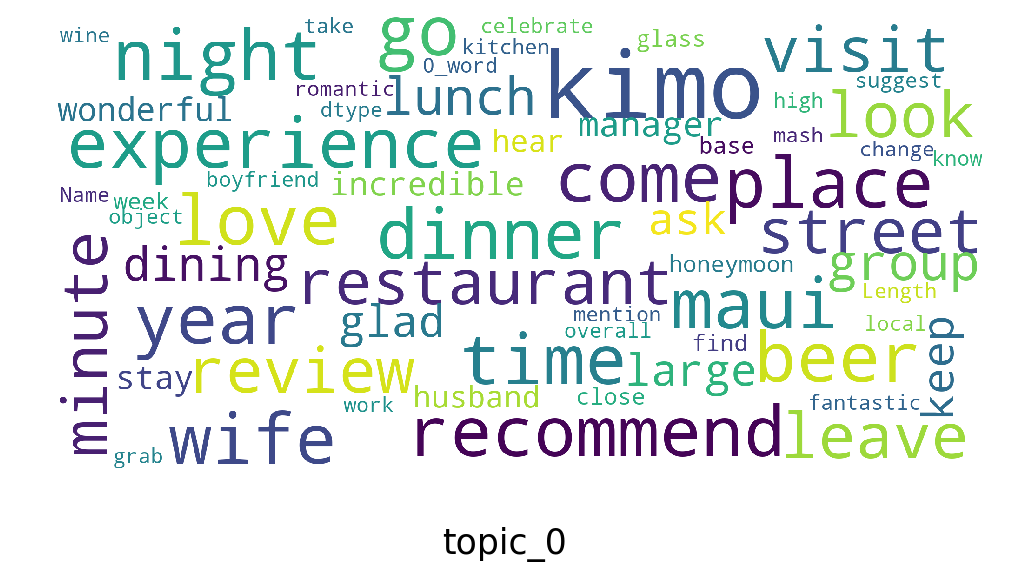

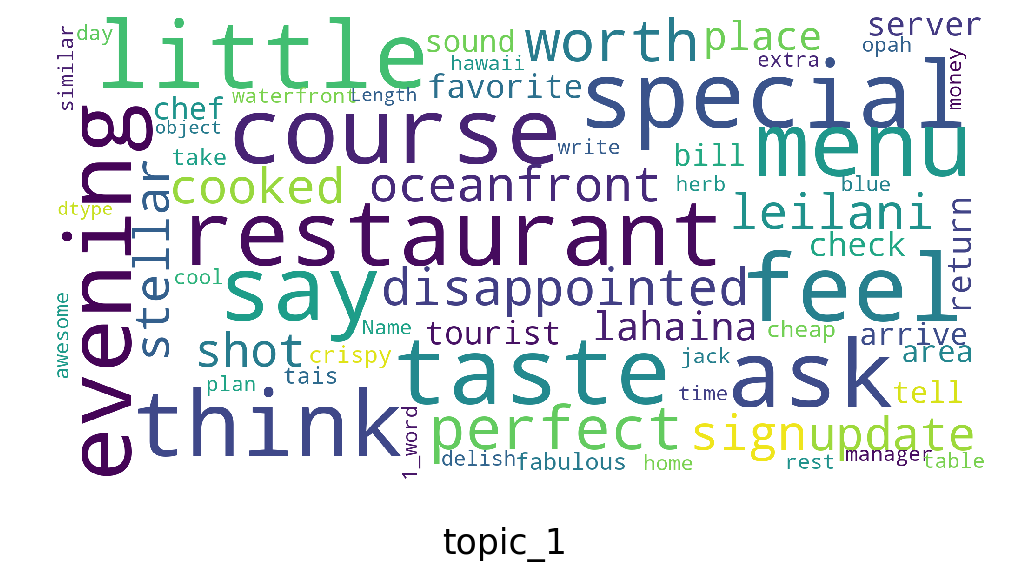

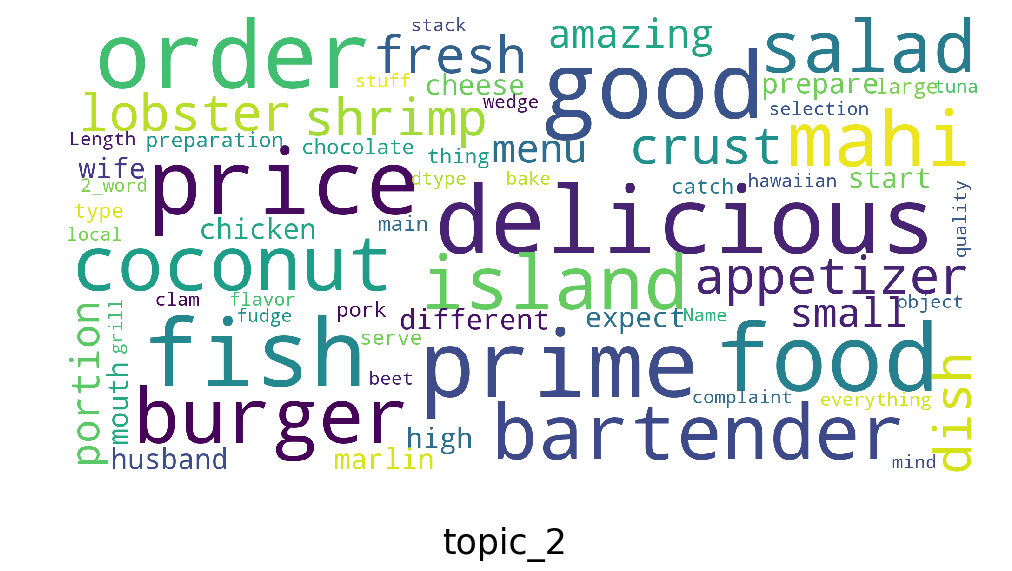

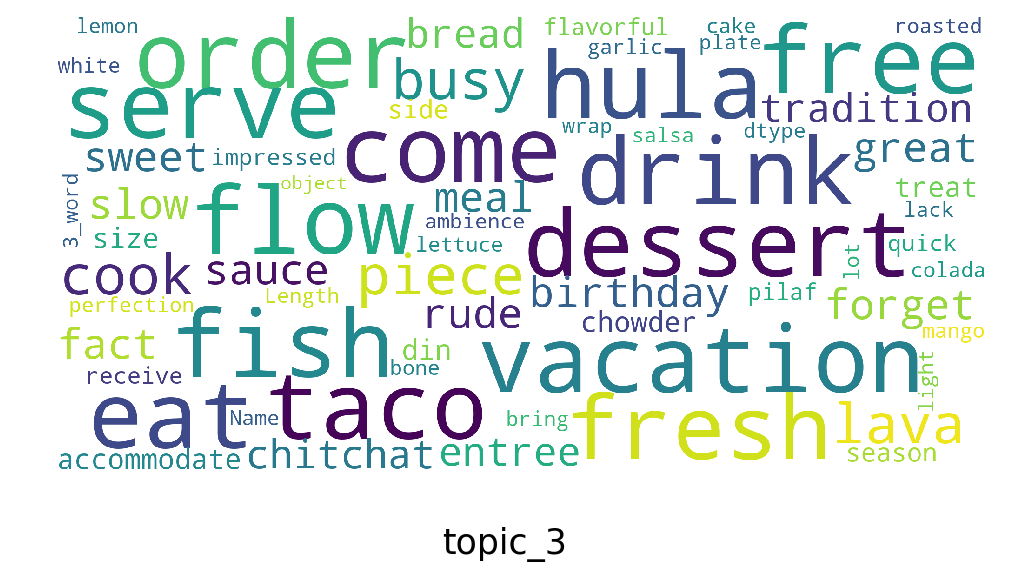

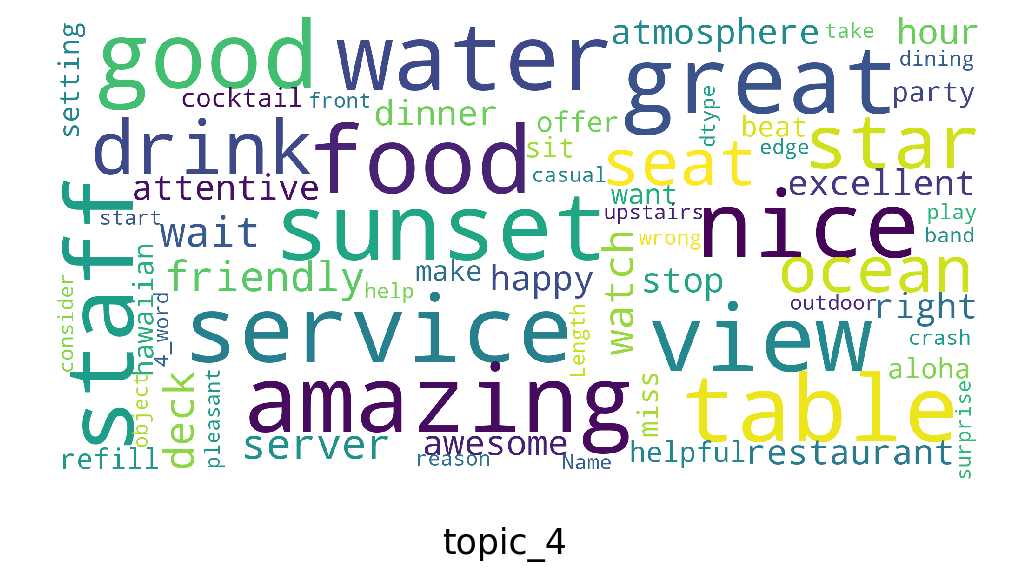

In [44]:
# words in the topics for selected model
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

for i in range(5):
    wordcloud = WordCloud(
            background_color='white',
            # stopwords=stopwords,
            max_words=400,
            max_font_size=40, 
            scale=5,
            random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(pd_topics[f'{i}_word']))

    fig = plt.figure(1, figsize=(12, 12), dpi=100)    
    fig.suptitle(f'topic_{i}', fontsize=25)
    fig.subplots_adjust(top=2.3)
    plt.axis('off')
    plt.imshow(wordcloud)     
    plt.savefig(f'../../data/processed/hi_rws_0001_0256_topic_{i}.png')  
    plt.show()